In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Sahiwal/Sahiwal_43.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Sahiwal/Sahiwal_187.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Sahiwal/Sahiwal_61.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Sahiwal/Sahiwal_76.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Sahiwal/Sahiwal_99.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Sahiwal/Sahiwal_100.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Sahiwal/Sahiwal_127.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Sahiwal/Sahiwal_124.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Sahiwal/Sahiwal_81.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Sahiwal/Sahiwal_196

In [2]:
# Cell 1 — MUST RUN FIRST (before importing TensorFlow)
# Installs compatible protobuf and sets env flags to avoid cu* registration + protobuf mismatch.



import os
# Environment fixes (must be set before importing tensorflow)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

print("Env prepared. Now run the next cell to import TensorFlow.")


Env prepared. Now run the next cell to import TensorFlow.


In [3]:
# Cell 2 - imports & config
import os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import cv2

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DATASET_DIR = "/kaggle/input/indian-bovine-breeds"   # your dataset path
print("TF", tf.__version__, "GPUs:", tf.config.list_physical_devices("GPU"))


E0000 00:00:1763528834.922260      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763528834.974965      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TF 2.18.0 GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
# Cell 3 - preprocessing (auto-detect + load)
IMG_SIZE = (380, 380)   # you can change to (300,300) if OOM
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def find_class_folder(base_path):
    for root, dirs, files in os.walk(base_path):
        dirs_filtered = [d for d in dirs if not d.startswith('.')]
        if len(dirs_filtered) > 1:
            print("Detected class folder:", root)
            print("Example classes:", dirs_filtered[:10])
            return root
    raise FileNotFoundError("No class folders found under: " + base_path)

CLASS_FOLDER = find_class_folder(DATASET_DIR)

train_ds = image_dataset_from_directory(
    CLASS_FOLDER,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)
val_ds = image_dataset_from_directory(
    CLASS_FOLDER,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# read class_names BEFORE prefetch/cache (important)
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", NUM_CLASSES, class_names)

# speed
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


Detected class folder: /kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds
Example classes: ['Sahiwal', 'Kankrej', 'Brown_Swiss', 'Nagpuri', 'Red_Dane', 'Murrah', 'Hallikar', 'Tharparkar', 'Ayrshire', 'Red_Sindhi']
Found 2517 files belonging to 14 classes.
Using 2014 files for training.


I0000 00:00:1763528850.967366      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763528850.968199      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2517 files belonging to 14 classes.
Using 503 files for validation.
Classes: 14 ['Ayrshire', 'Brown_Swiss', 'Gir', 'Hallikar', 'Holstein_Friesian', 'Jersey', 'Kankrej', 'Murrah', 'Nagpuri', 'Ongole', 'Red_Dane', 'Red_Sindhi', 'Sahiwal', 'Tharparkar']


In [5]:
# Cell 4 - compute class weights (helps with imbalance)
all_labels = []
for imgs, labels in train_ds.unbatch().batch(10000):
    all_labels.extend(labels.numpy().tolist())
all_labels = np.array(all_labels)
classes = np.unique(all_labels)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights = dict(enumerate(cw))
print("class_weights:", class_weights)


class_weights: {0: 0.9786200194363459, 1: 0.9402427637721755, 2: 0.972007722007722, 3: 1.0202634245187436, 4: 1.0275510204081633, 5: 0.9990079365079365, 6: 1.0500521376433785, 7: 0.959047619047619, 8: 0.9921182266009853, 9: 1.0735607675906182, 10: 0.972007722007722, 11: 0.9786200194363459, 12: 1.0130784708249496, 13: 1.0424430641821947}


In [6]:
# Cell 5 - augmentation (safe TF layers)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomContrast(0.12),
], name="data_augmentation")

def augment(images, labels):
    images = tf.cast(images, tf.float32)
    images = data_augmentation(images, training=True)
    return images, labels

train_ds_aug = train_ds.map(augment, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds_ready = val_ds.prefetch(AUTOTUNE)


In [7]:
# Cell 6 - reusable training function
def train_feature_and_finetune(model, base, train_ds, val_ds, class_weights,
                               warmup_epochs=8, finetune_epochs=20, unfreeze_layers=60,
                               warmup_lr=1e-3, finetune_lr=1e-5, save_prefix="model"):
    # Warmup callbacks
    ck_warm = ModelCheckpoint(f"{save_prefix}_warmup.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
    rl_warm = ReduceLROnPlateau(monitor="val_loss", factor=0.4, patience=3, min_lr=1e-7, verbose=1)
    es_warm = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=warmup_lr),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("Starting warmup (feature extraction)...")
    history_warm = model.fit(train_ds, validation_data=val_ds, epochs=warmup_epochs,
                             callbacks=[ck_warm, rl_warm, es_warm], class_weight=class_weights, verbose=1)

    # Fine-tuning: unfreeze top layers of base
    print("Preparing for fine-tuning...")
    for layer in base.layers[-unfreeze_layers:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=finetune_lr),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    ck_ft = ModelCheckpoint(f"{save_prefix}_finetuned.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
    rl_ft = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-8, verbose=1)
    es_ft = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

    print("Starting fine-tuning...")
    history_ft = model.fit(train_ds, validation_data=val_ds, epochs=finetune_epochs,
                           callbacks=[ck_ft, rl_ft, es_ft], class_weight=class_weights, verbose=1)

    return history_warm, history_ft


In [8]:
# Cell 7 - EfficientNetB3
from tensorflow.keras.applications import EfficientNetB3

def build_effnetb3(num_classes, img_size=IMG_SIZE, dropout_rate=0.4):
    base = EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_size + (3,))
    base.trainable = False
    inputs = layers.Input(shape=img_size + (3,))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model, base

model, base = build_effnetb3(NUM_CLASSES)
model.summary()

# Train
history_warm, history_ft = train_feature_and_finetune(
    model, base, train_ds_aug, val_ds_ready, class_weights,
    warmup_epochs=8, finetune_epochs=20, unfreeze_layers=60,
    warmup_lr=1e-3, finetune_lr=1e-5, save_prefix="efficientnetb3"
)


43941136/43941136 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 efficientnetb3 (Functional  (None, 12, 12, 1536)      10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 14)                21518     
                                                              

I0000 00:00:1763528891.532869      64 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763528894.757636      65 service.cc:148] XLA service 0x7e5d5470aa60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763528894.758158      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763528894.758183      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763528894.932979      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


126/126 [==============================] - ETA: 0s - loss: 2.0002 - accuracy: 0.3764
Epoch 1: val_accuracy improved from -inf to 0.58250, saving model to efficientnetb3_warmup.keras
126/126 [==============================] - 57s 343ms/step - loss: 2.0002 - accuracy: 0.3764 - val_loss: 1.4746 - val_accuracy: 0.5825 - lr: 0.0010
Epoch 2/8
126/126 [==============================] - ETA: 0s - loss: 1.3928 - accuracy: 0.5591
Epoch 2: val_accuracy improved from 0.58250 to 0.65408, saving model to efficientnetb3_warmup.keras
126/126 [==============================] - 40s 309ms/step - loss: 1.3928 - accuracy: 0.5591 - val_loss: 1.2170 - val_accuracy: 0.6541 - lr: 0.0010
Epoch 3/8
126/126 [==============================] - ETA: 0s - loss: 1.1941 - accuracy: 0.6177
Epoch 3: val_accuracy improved from 0.65408 to 0.67992, saving model to efficientnetb3_warmup.keras
126/126 [==============================] - 41s 321ms/step - loss: 1.1941 - accuracy: 0.6177 - val_loss: 1.0967 - val_accuracy: 0.6799 

In [9]:
import numpy as np

# Extract true labels from validation dataset
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# Convert one-hot labels to integer class labels if needed
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true_labels = np.argmax(y_true, axis=1)
else:
    y_true_labels = y_true

# Get model predictions
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


32/32 [==============================] - 7s 170ms/step


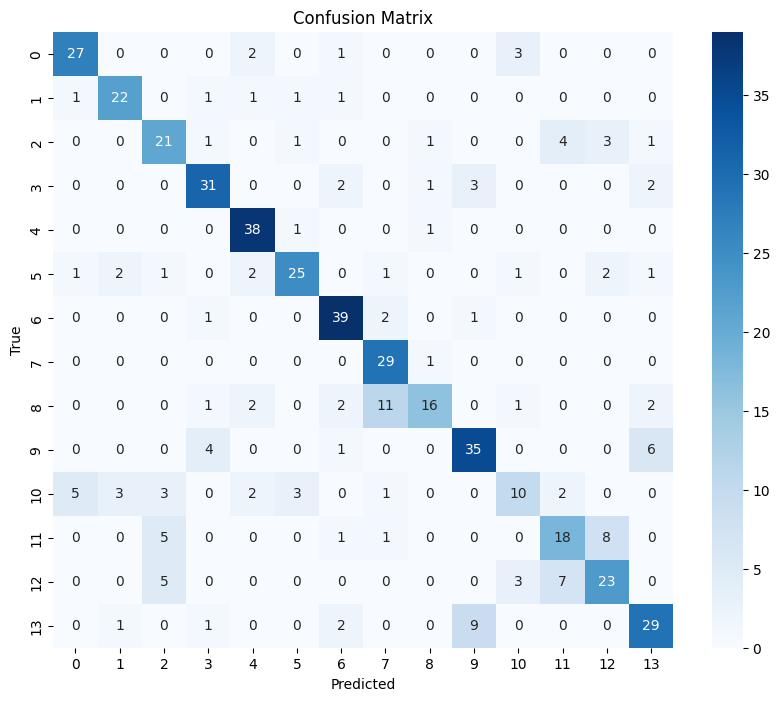

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_labels, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_true_labels, y_pred)
precision = precision_score(y_true_labels, y_pred, average='weighted')
recall = recall_score(y_true_labels, y_pred, average='weighted')
f1 = f1_score(y_true_labels, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}\n")

print("Classification Report:\n", classification_report(y_true_labels, y_pred))


Accuracy: 0.7217
Precision: 0.7208
Recall: 0.7217
F1 Score: 0.7134

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81        33
           1       0.79      0.81      0.80        27
           2       0.60      0.66      0.63        32
           3       0.78      0.79      0.78        39
           4       0.81      0.95      0.87        40
           5       0.81      0.69      0.75        36
           6       0.80      0.91      0.85        43
           7       0.64      0.97      0.77        30
           8       0.80      0.46      0.58        35
           9       0.73      0.76      0.74        46
          10       0.56      0.34      0.43        29
          11       0.58      0.55      0.56        33
          12       0.64      0.61      0.62        38
          13       0.71      0.69      0.70        42

    accuracy                           0.72       503
   macro avg       0.72      0.71      0.7

In [12]:
def combine_history(history1, history2):
    combined = {}
    for key in history1.history.keys():
        combined[key] = history1.history[key] + history2.history[key]
    return combined

history_combined = combine_history(history_warm, history_ft)


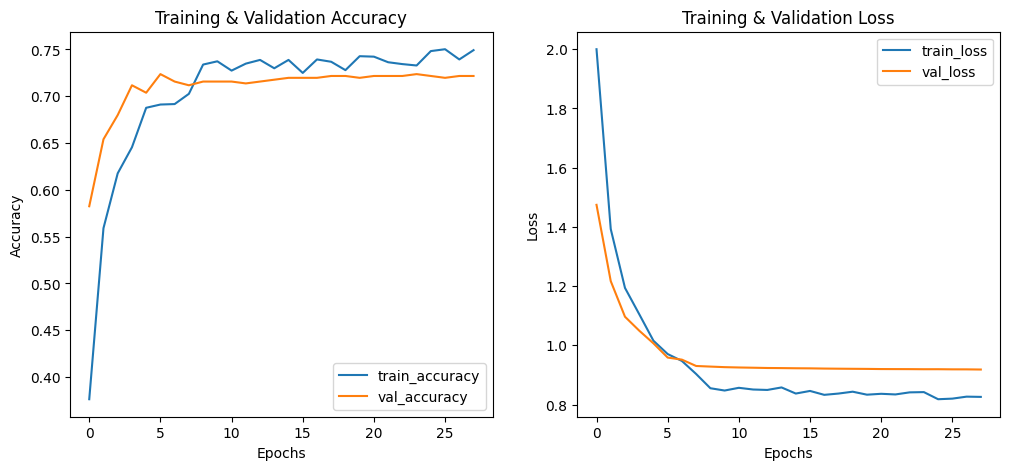

In [13]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_combined['accuracy'], label='train_accuracy')
plt.plot(history_combined['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_combined['loss'], label='train_loss')
plt.plot(history_combined['val_loss'], label='val_loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [14]:
# Cell 8 - EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0

def build_effnetb0(num_classes, img_size=IMG_SIZE, dropout_rate=0.4):
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=img_size + (3,))
    base.trainable = False
    inputs = layers.Input(shape=img_size + (3,))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model, base

model, base = build_effnetb0(NUM_CLASSES)
model.summary()

history_warm, history_ft = train_feature_and_finetune(
    model, base, train_ds_aug, val_ds_ready, class_weights,
    warmup_epochs=8, finetune_epochs=18, unfreeze_layers=50,
    warmup_lr=1e-3, finetune_lr=1e-5, save_prefix="efficientnetb0"
)


16705208/16705208 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 12, 12, 1280)      4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 14)                17934     
                                                            

In [15]:
import numpy as np

# Extract true labels from validation dataset
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# Convert one-hot labels to integer labels if needed
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true_labels = np.argmax(y_true, axis=1)
else:
    y_true_labels = y_true

# Get model predictions
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


32/32 [==============================] - 5s 89ms/step


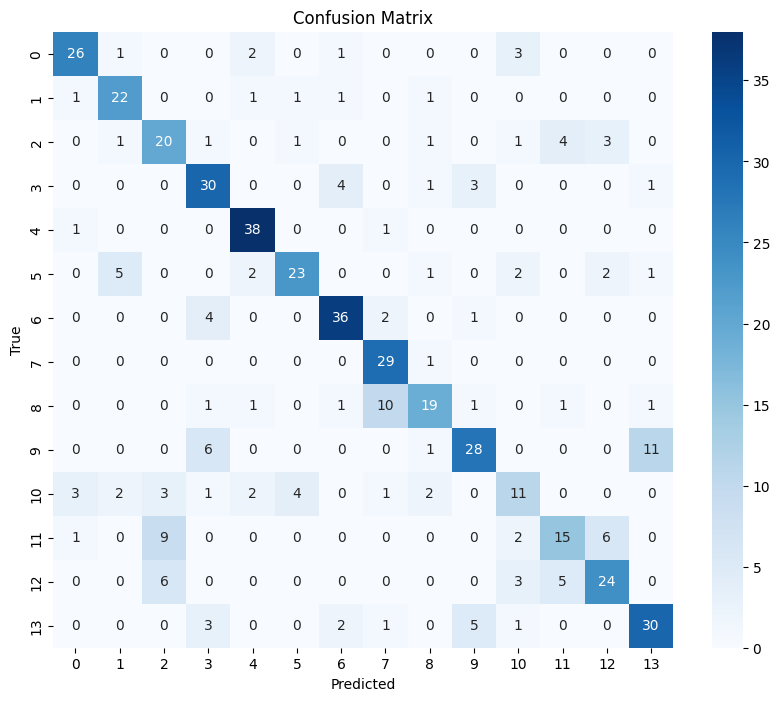

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_labels, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Overall metrics
accuracy = accuracy_score(y_true_labels, y_pred)
precision = precision_score(y_true_labels, y_pred, average='weighted')
recall = recall_score(y_true_labels, y_pred, average='weighted')
f1 = f1_score(y_true_labels, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}\n")

# Detailed per-class metrics
print(classification_report(y_true_labels, y_pred))


Accuracy: 0.6978
Precision: 0.6976
Recall: 0.6978
F1 Score: 0.6918

              precision    recall  f1-score   support

           0       0.81      0.79      0.80        33
           1       0.71      0.81      0.76        27
           2       0.53      0.62      0.57        32
           3       0.65      0.77      0.71        39
           4       0.83      0.95      0.88        40
           5       0.79      0.64      0.71        36
           6       0.80      0.84      0.82        43
           7       0.66      0.97      0.78        30
           8       0.70      0.54      0.61        35
           9       0.74      0.61      0.67        46
          10       0.48      0.38      0.42        29
          11       0.60      0.45      0.52        33
          12       0.69      0.63      0.66        38
          13       0.68      0.71      0.70        42

    accuracy                           0.70       503
   macro avg       0.69      0.69      0.69       503
weighted avg

In [18]:
# Combine warmup and finetuning histories for plotting
def combine_history(history1, history2):
    combined = {}
    for key in history1.history.keys():
        combined[key] = history1.history[key] + history2.history[key]
    return combined

history_combined = combine_history(history_warm, history_ft)


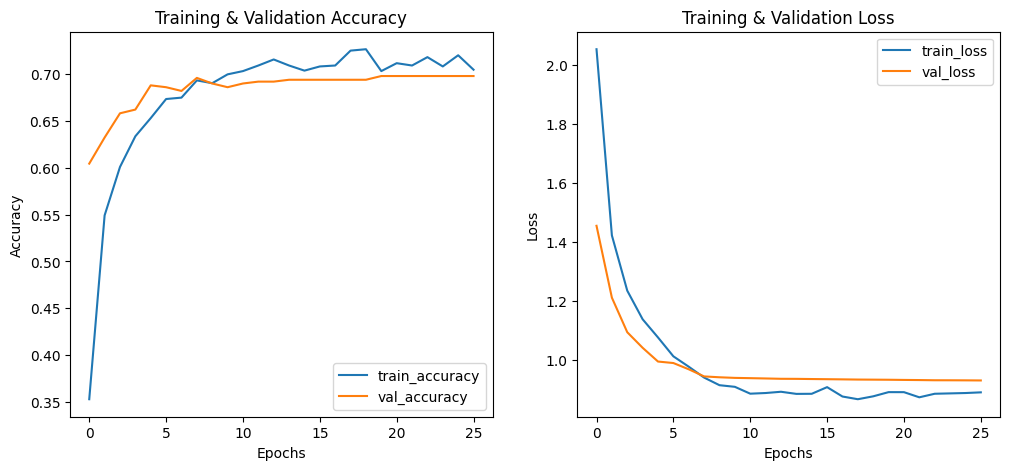

In [19]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_combined['accuracy'], label='train_accuracy')
plt.plot(history_combined['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_combined['loss'], label='train_loss')
plt.plot(history_combined['val_loss'], label='val_loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [20]:
# Cell 10 - DenseNet121
from tensorflow.keras.applications import DenseNet121

def build_densenet121(num_classes, img_size=IMG_SIZE, dropout_rate=0.4):
    base = DenseNet121(include_top=False, weights='imagenet', input_shape=img_size + (3,))
    base.trainable = False
    inputs = layers.Input(shape=img_size + (3,))
    x = tf.keras.applications.densenet.preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model, base

model, base = build_densenet121(NUM_CLASSES)
model.summary()

history_warm, history_ft = train_feature_and_finetune(
    model, base, train_ds_aug, val_ds_ready, class_weights,
    warmup_epochs=8, finetune_epochs=18, unfreeze_layers=60,
    warmup_lr=1e-3, finetune_lr=1e-5, save_prefix="densenet121"
)

29084464/29084464 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 380, 380, 3)       0         
 a)                                                              
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 380, 380, 3)       0         
 )                                                               
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 380, 380, 3)       0         
 bda)                                                            
                                                                 
 densenet121 (Functional)    (None, 11, 11, 1024)      70375

In [21]:
import numpy as np

# Get true labels and predicted labels
y_true = np.concatenate([y for x, y in val_ds_ready], axis=0)  # True labels
y_pred_probs = model.predict(val_ds_ready, verbose=1)           # Model probabilities
y_pred = np.argmax(y_pred_probs, axis=1)                        # Predicted labels


32/32 [==============================] - 7s 162ms/step


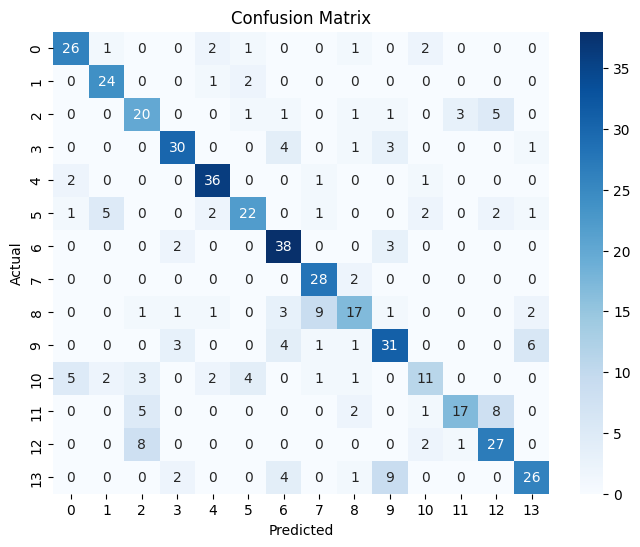

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [23]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.7647    0.7879    0.7761        33
           1     0.7500    0.8889    0.8136        27
           2     0.5405    0.6250    0.5797        32
           3     0.7895    0.7692    0.7792        39
           4     0.8182    0.9000    0.8571        40
           5     0.7333    0.6111    0.6667        36
           6     0.7037    0.8837    0.7835        43
           7     0.6829    0.9333    0.7887        30
           8     0.6296    0.4857    0.5484        35
           9     0.6458    0.6739    0.6596        46
          10     0.5789    0.3793    0.4583        29
          11     0.8095    0.5152    0.6296        33
          12     0.6429    0.7105    0.6750        38
          13     0.7222    0.6190    0.6667        42

    accuracy                         0.7018       503
   macro avg     0.7008    0.6988    0.6916       503
weighted avg     0.7027    0.7018    0.6947       503



In [24]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {acc:.4f}")


Validation Accuracy: 0.7018


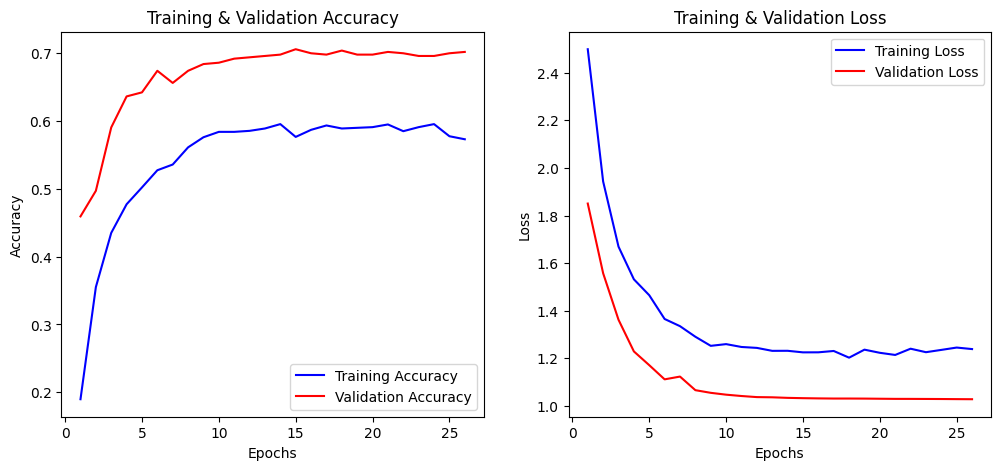

In [25]:
# Combine warmup + fine-tuning history
acc = history_warm.history['accuracy'] + history_ft.history['accuracy']
val_acc = history_warm.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history_warm.history['loss'] + history_ft.history['loss']
val_loss = history_warm.history['val_loss'] + history_ft.history['val_loss']

epochs = range(1, len(acc)+1)

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [26]:
# Cell 11 - MobileNetV2
from tensorflow.keras.applications import MobileNetV2

def build_mobilenetv2(num_classes, img_size=IMG_SIZE, dropout_rate=0.4):
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=img_size + (3,))
    base.trainable = False
    inputs = layers.Input(shape=img_size + (3,))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model, base

model, base = build_mobilenetv2(NUM_CLASSES)
model.summary()

history_warm, history_ft = train_feature_and_finetune(
    model, base, train_ds_aug, val_ds_ready, class_weights,
    warmup_epochs=8, finetune_epochs=18, unfreeze_layers=50,
    warmup_lr=1e-3, finetune_lr=1e-5, save_prefix="mobilenetv2"
)

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 380, 380, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract (TFOpLamb  (None, 380, 380, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 12, 12, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0      

In [27]:
import numpy as np

# True labels
y_true = np.concatenate([y for x, y in val_ds_ready], axis=0)

# Predicted probabilities
y_pred_probs = model.predict(val_ds_ready, verbose=1)

# Predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)


32/32 [==============================] - 3s 58ms/step


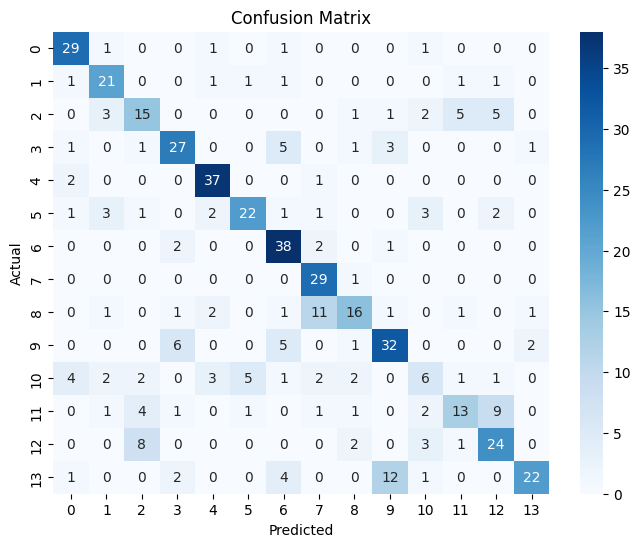

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [29]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.7436    0.8788    0.8056        33
           1     0.6562    0.7778    0.7119        27
           2     0.4839    0.4688    0.4762        32
           3     0.6923    0.6923    0.6923        39
           4     0.8043    0.9250    0.8605        40
           5     0.7586    0.6111    0.6769        36
           6     0.6667    0.8837    0.7600        43
           7     0.6170    0.9667    0.7532        30
           8     0.6400    0.4571    0.5333        35
           9     0.6400    0.6957    0.6667        46
          10     0.3333    0.2069    0.2553        29
          11     0.5909    0.3939    0.4727        33
          12     0.5714    0.6316    0.6000        38
          13     0.8462    0.5238    0.6471        42

    accuracy                         0.6581       503
   macro avg     0.6460    0.6509    0.6365       503
weighted avg     0.6554    0.6581    0.6450       503



In [30]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.6581


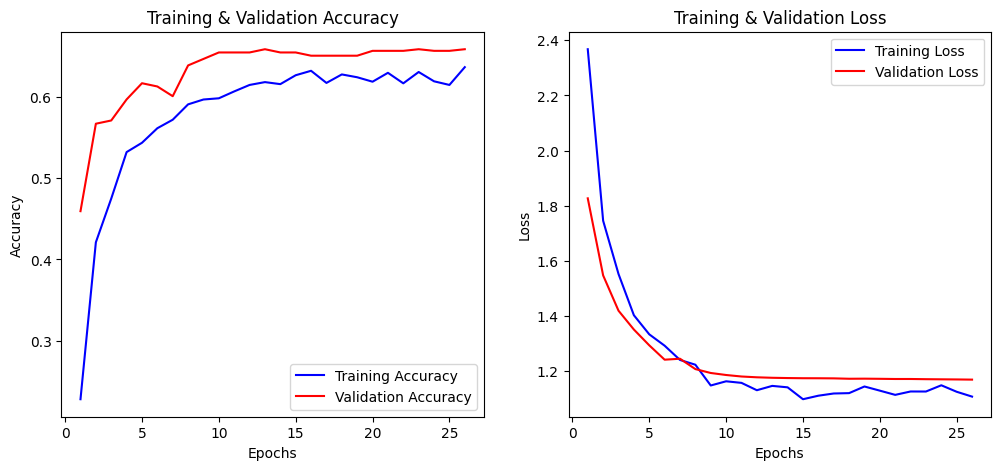

In [31]:
# Combine warmup + fine-tuning history
acc = history_warm.history['accuracy'] + history_ft.history['accuracy']
val_acc = history_warm.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history_warm.history['loss'] + history_ft.history['loss']
val_loss = history_warm.history['val_loss'] + history_ft.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [32]:
# ================================================================
# SINGLE BLOCK — EfficientNetB3 + DenseNet121 Fusion Model Training
# ================================================================
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3, DenseNet121
import numpy as np
import os

# -----------------------------
# 1. DATASET PATH
# -----------------------------
DATA_PATH = "/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds"
IMG_SIZE = (224, 224)
BATCH = 16

In [33]:
# 2. DATA LOADERS
# -----------------------------
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

val_gen = ImageDataGenerator(rescale=1./255, validation_split=0.20)

train_ds = train_gen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="categorical",
    subset="training",
    shuffle=True
)
val_ds = val_gen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

NUM_CLASSES = len(train_ds.class_indices)
print("Detected classes:", NUM_CLASSES, train_ds.class_indices)

# -----------------------------
# 3. BUILD FUSION MODEL
# -----------------------------
effnet = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3),
    pooling="avg"
)
effnet.trainable = False

densenet = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3),
    pooling="avg"
)
densenet.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3))

x1 = effnet(inputs)
x2 = densenet(inputs)

fusion = layers.Concatenate()([x1, x2])
fusion = layers.Dense(512, activation="relu")(fusion)
fusion = layers.Dropout(0.3)(fusion)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(fusion)

model = Model(inputs, outputs)

# Short summary (avoids huge print)
print("Total Trainable Params:", model.count_params())

# -----------------------------
# 4. COMPILE + TRAINING
# -----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("fusion_model.h5", save_best_only=True, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks,
    verbose=1
)

# -----------------------------
# 5. SAVE FINAL MODEL
# -----------------------------
model.save("EffNetB3_DenseNet121_FUSION.h5")
print("Model saved successfully!")


Found 2007 images belonging to 14 classes.
Found 500 images belonging to 14 classes.
Detected classes: 14 {'Ayrshire': 0, 'Brown_Swiss': 1, 'Gir': 2, 'Hallikar': 3, 'Holstein_Friesian': 4, 'Jersey': 5, 'Kankrej': 6, 'Murrah': 7, 'Nagpuri': 8, 'Ongole': 9, 'Red_Dane': 10, 'Red_Sindhi': 11, 'Sahiwal': 12, 'Tharparkar': 13}
Total Trainable Params: 19139453
Epoch 1/25


E0000 00:00:1763532915.032084      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 34/126 [=======>......................] - ETA: 30s - loss: 2.7183 - accuracy: 0.1176

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


126/126 [==============================] - ETA: 0s - loss: 2.4265 - accuracy: 0.2008
Epoch 1: val_loss improved from inf to 2.01090, saving model to fusion_model.h5


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


126/126 [==============================] - 70s 437ms/step - loss: 2.4265 - accuracy: 0.2008 - val_loss: 2.0109 - val_accuracy: 0.3820 - lr: 1.0000e-04
Epoch 2/25
126/126 [==============================] - ETA: 0s - loss: 1.8989 - accuracy: 0.3906
Epoch 2: val_loss improved from 2.01090 to 1.65455, saving model to fusion_model.h5
126/126 [==============================] - 49s 391ms/step - loss: 1.8989 - accuracy: 0.3906 - val_loss: 1.6546 - val_accuracy: 0.4980 - lr: 1.0000e-04
Epoch 3/25
126/126 [==============================] - ETA: 0s - loss: 1.6450 - accuracy: 0.4704
Epoch 3: val_loss improved from 1.65455 to 1.48888, saving model to fusion_model.h5
126/126 [==============================] - 48s 384ms/step - loss: 1.6450 - accuracy: 0.4704 - val_loss: 1.4889 - val_accuracy: 0.5440 - lr: 1.0000e-04
Epoch 4/25
126/126 [==============================] - ETA: 0s - loss: 1.4802 - accuracy: 0.5147
Epoch 4: val_loss improved from 1.48888 to 1.40584, saving model to fusion_model.h5
126/126